In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Demo of using datapipe-testbench for performance benchmarks

A few notes on how `datapipe-testbench` works:

Procedural Terminology
* **Experiment**: A data processing trial with a fixed analysis or instrumental _configuration_, that produces pre-processed data that can be used as inputs for a benchmark. 
* **Study**: the act of comparing several experiments to generate a report.
* **Configuration**: the set of parameters used 


Examples:
- "_Study_ the difference in sensitivity between three _experiments_: CTAO-North at 3 different zenith angles"


* **InputDataset**: set of pre-processed data products corresponding to a single _experiment_
* **Benchmark**: code that defines ways of processing and `InputDatasets` from one or more _experiments_. Each benchmark defines:
   1. **Metrics** that can be extracted from one experiment's input data (the set of which is stored in a `MetricsStore`, per Experiment). 
   2. **Reports** plots or serialized results that compare the metrics from N experiments. (stored in a `ReportsStore`, per Study)
* **Store**: a serialized set of objects and metadata that can be shared or loaded back up later. 


Code explanation:
1. Each `Benchmark` defines transformations from a single `InputDataset` to a set of *metrics* stored in a single `MetricsStore`.  Once this transformation is made, the original `InputDataset` is no longer needed, as all relevant info has been summarized into the output metrics. Therefore this transformation can be made once per experiement, and does not have to be done together. The idea is that user can pre-generate metrics for each experiment, keep them in one central place on disk, and later do any comparison they want between them.  
1. Each `Benchmark` therefore also defines a set of comparisons and output plots that convert a set of `MetricStores` into a `ReportStore`, and can also generate a PDF report summarizing them. 





## Demo the high-level DL3 performance comparison

- **Benchmark**: we will use the `IRFBenchmark` only here. It generates the metrics needed for comparison sensitivities.
- **Inputs**: this benchmark requires only a subset of inputs, namely the outputs of `ctapipe-compute-irf`

In [20]:
import logging
from pathlib import Path

import graphviz
import matplotlib.pyplot as plt

from datapipe_testbench import benchmarks
from datapipe_testbench.benchmark import MissingInputError
from datapipe_testbench.store import InputDataset, MetricsStore, ResultStore
from datapipe_testbench.visualization import graphviz_inputs_to_benchmarks

# Define the benchmark(s) to use for our study.

 In general we could use more than one, and loop over them, but here we only need a single benchmark. 

In [21]:
benchmark_list = [
    benchmarks.dl3.IRFBenchmark(), # we only have one for this example
]
experiments_path = Path("/tmp/Experiments")
results_path = Path("/tmp/Studies")

In [22]:
def print_benchmark_info(benchmark):
    print(benchmark.name)
    print("-" * 40)
    print(benchmark.__doc__)
    print("Input Files Required for Metric Generation:")
    for req in list(benchmark.required_inputs):
        print(f" * {req}")
    print()
    print("Output Metrics:")
    for name, output in benchmark.output_names.items():
        print(f" * {name:20s}: {output}")
    print()


# just print out some useful info about the benchmark:
for benchmark in benchmark_list:
    print_benchmark_info(benchmark)

IRF Benchmark
----------------------------------------
Top level performance benchmarks.

Coverst requirements:
PROG-0020, PROG-0030, PROG-0040, PROG-0050,
PROG-0060, PROG-0070, PROG-0080, PROG-0090

For generation, requires:
* GADF IRF files

Input Files Required for Metric Generation:
 * dl3_irf
 * dl3_benchmark

Output Metrics:
 * background          : dl3/instrument_response_functions/Background.asdf
 * effective area      : dl3/instrument_response_functions/EffectiveArea.asdf
 * energy migration    : dl3/instrument_response_functions/EnergyMigration.asdf
 * rad max             : dl3/instrument_response_functions/RadMax.asdf
 * angular resolution  : dl3/instrument_response_functions/AngularResolution.asdf
 * energy bias resolution: dl3/instrument_response_functions/EnergyBiasResolution.asdf
 * sensitivity         : dl3/instrument_response_functions/Sensitivity.asdf



### Prepare the inputs

For each experiment, process inputs into metrics. See the info above to understand what inpnuts are needed for the selected benchmarks.  Since so far, we only chose to look at the IRF Performance benchmark, it only needs IRF files. Those can be created from event data as follows, where the gamma, electrons, and protons files are those you generate with ctapipe-process:

For this benchmark, We only need to provide the `dl3_irf` and `dl3_benchmarks` inputs, which are the two files created when you run `ctapipe-compute-irf`, e.g. using the following: 

```bash
# generates cuts.fits.gz:
ctapipe-optimize-event-selection \
    --config optimize-config.yaml \
    --gamma-file=gammas.DL2.h5 \
    --electron-file=electrons.DL2.h5 \
    --proton-file=protons.DL2.h5 \
    --output cuts.fits.gz

# generates irf.fits.gz and benchmarks.fits.gz
ctapipe-compute-irf \
    --config irf-config.yaml \
    --cuts cuts.fits.gz \
    --gamma-file=gammas.DL2.h5 \
    --electron-file=electrons.DL2.h5 \
    --proton-file=protons.DL2.h5 \
    --output irf.fits.gz \
    --benchmark-output benchmarks.fits.gz \   
```

It's important to use the `--benchmark-output` option when making the IRFs, since this is what is plotted here. In fact, this benchmark does no computation, it just reads this file (unlike other benchmarks)

Note the config files can be generated from `ctapipe-quickstart`, but I would suggest being careful to edit them to do what you want as the defaults may not be very useful. They were made for testing, not for good performance.


### Define the inputs

For pre-processing, we need list of `InputDatasets`:

In [23]:
official_prod5 = InputDataset(
    name="Official Prod5 CTAO-South Alpha 20deg 50h",
    dl3_irf="/Users/kkosack/Sync/CTA/DataPipe/DataPipeTestbenchData/Prod5-South-20deg-SouthAz-14MSTs37SSTs.50h_pointlike_test.fits",
    dl3_benchmark="/Users/kkosack/Sync/CTA/DataPipe/DataPipeTestbenchData/Prod5-South-20deg-SouthAz-14MSTs37SSTs.50h_pointlike_benchmarks.fits",
)

prod6_000 = InputDataset(
    name="prod6-north-alpha_zen20_az000",
    dl3_irf="/Users/kkosack/Data/CTA/Prod6/North_Alpha_Zen20_Az000_NSB01/irf_Point_50h.fits",
    dl3_benchmark="/Users/kkosack/Data/CTA/Prod6/North_Alpha_Zen20_Az000_NSB01/benchmarks_Point_50h.fits",
)

prod6_180 = InputDataset(
    name="prod6-north-alpha_zen20_az180",
    dl3_irf="/Users/kkosack/Data/CTA/Prod6/North_Alpha_Zen20_Az180_NSB01/irf_Point_50h.fits",
    dl3_benchmark="/Users/kkosack/Data/CTA/Prod6/North_Alpha_Zen20_Az180_NSB01/benchmarks_Point_50h.fits",
)

std_window = InputDataset(
    name="Standard_Window",
    dl3_irf="/scr/punch/CTA/Prod6/LaPalma/2025/irf.std.fits",
    dl3_benchmark="/scr/punch/CTA/Prod6/LaPalma/2025/benchmark.std.fits",
)

red_window = InputDataset(
    name="Reduced_Window",
    dl3_irf="/scr/punch/CTA/Prod6/LaPalma/2025/irf.red.fits",
    dl3_benchmark="/scr/punch/CTA/Prod6/LaPalma/2025/benchmark.red.fits",
)


In [24]:
input_list = [ std_window, red_window ] # official_prod5, prod6_000, prod6_180]

We can visualize the connections between the InputDatasets (our experiments), and the Benchmarks we want to apply them to:

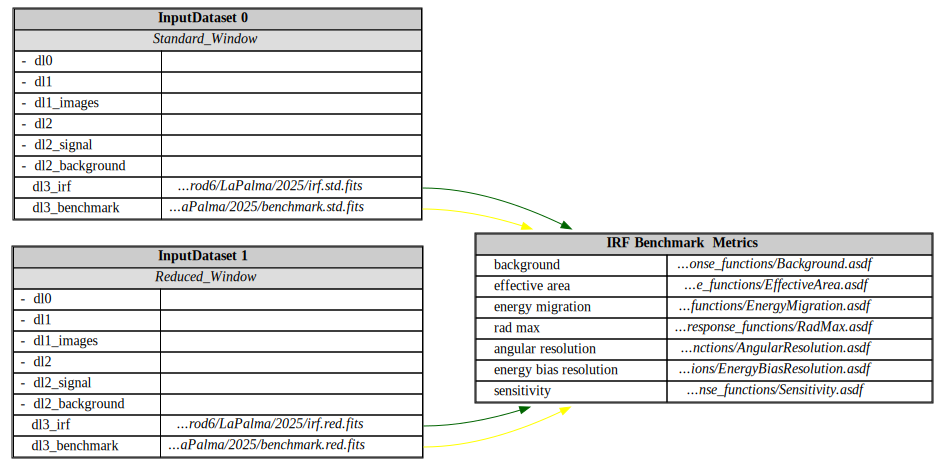

In [25]:
graph = graphviz_inputs_to_benchmarks(input_list, benchmark_list, file_length=30)
graph

### Pre-process the InputDatasets into MetricStores

For each experiment's input_dataset, we will create a MetricStore with the same name, and run `benchmark.generate_metrics()` to fill it with the data:

In [29]:
metric_store_list = []
for input_dataset in input_list:
    print(f"* PROCESSING {input_dataset.name}")
    metrics = MetricsStore.from_path_and_input_dataset(
        experiments_path / input_dataset.name, input_dataset.to_dict()
    )
    metric_store_list.append(metrics)
    for benchmark in benchmark_list:
        print(f"    * GENERATING Metrics for: {benchmark.__class__.__name__}")
        try:
            benchmark.check_input_dataset(metrics.get_inputdata())
            benchmark.generate_metrics(metrics)
        except MissingInputError as err:
            print(f"       -> {err}")

* PROCESSING Standard_Window
    * GENERATING Metrics for: IRFBenchmark
* PROCESSING Reduced_Window
    * GENERATING Metrics for: IRFBenchmark


In [30]:
!tree $experiments_path

/tmp/Experiments
├── Reduced_Window
│   ├── dl3
│   │   └── instrument_response_functions
│   │       ├── AngularResolution.asdf
│   │       ├── Background.asdf
│   │       ├── EffectiveArea.asdf
│   │       ├── EnergyBiasResolution.asdf
│   │       ├── EnergyMigration.asdf
│   │       ├── RadMax.asdf
│   │       └── Sensitivity.asdf
│   └── metadata.json
└── Standard_Window
    ├── dl3
    │   └── instrument_response_functions
    │       ├── AngularResolution.asdf
    │       ├── Background.asdf
    │       ├── EffectiveArea.asdf
    │       ├── EnergyBiasResolution.asdf
    │       ├── EnergyMigration.asdf
    │       ├── RadMax.asdf
    │       └── Sensitivity.asdf
    └── metadata.json

7 directories, 16 files


## Make a Study that compares several Experiments

In the previous step, we wrote out MetricsStores for each of our experiments.  That has to happen only once per Experiment, and we can assume they are each stored in one place.  Then later, we can choose from our library of experiments, which ones to compare.  Here we will do that:

First, set a nice plotting style (feel free to use any in `plt.style.available` or set any matplotlib config parameters )

In [31]:
import matplotlib.pyplot as plt

#plt.style.use([{"axes.grid": True}, "vibrant"])

Now, let's load up the experiments. Each one is a MetricsStore object that cam be read from a Path using it's constructor:

In [32]:
experiments = [
    experiments_path / "Standard_Window",
    experiments_path / "Reduced_Window",
    
    #experiments_path / "Official Prod5 CTAO-South Alpha 20deg 50h",
    #experiments_path / "prod6-north-alpha_zen20_az000",
    #experiments_path / "prod6-north-alpha_zen20_az180",
]
loaded_metric_list = [MetricsStore(x) for x in experiments]

Now, we can genreate the comparison plots.  Again we have to make a list of benchmarks that work with these Metrics. SInce this is the same notebook, we'll just reuse the `benchmarks_list` we defined before:

/home/punch/miniconda3/envs/ctapipe_0.24/lib/python3.13/site-packages/mplhep/error_estimation.py:33: RuntimeWarning: invalid value encountered in divide
  scale[sumw != 0] = sumw2[sumw != 0] / sumw[sumw != 0]
/home/punch/miniconda3/envs/ctapipe_0.24/lib/python3.13/site-packages/mplhep/error_estimation.py:33: RuntimeWarning: invalid value encountered in divide
  scale[sumw != 0] = sumw2[sumw != 0] / sumw[sumw != 0]
/home/punch/miniconda3/envs/ctapipe_0.24/lib/python3.13/site-packages/mplhep/error_estimation.py:33: RuntimeWarning: invalid value encountered in divide
  scale[sumw != 0] = sumw2[sumw != 0] / sumw[sumw != 0]


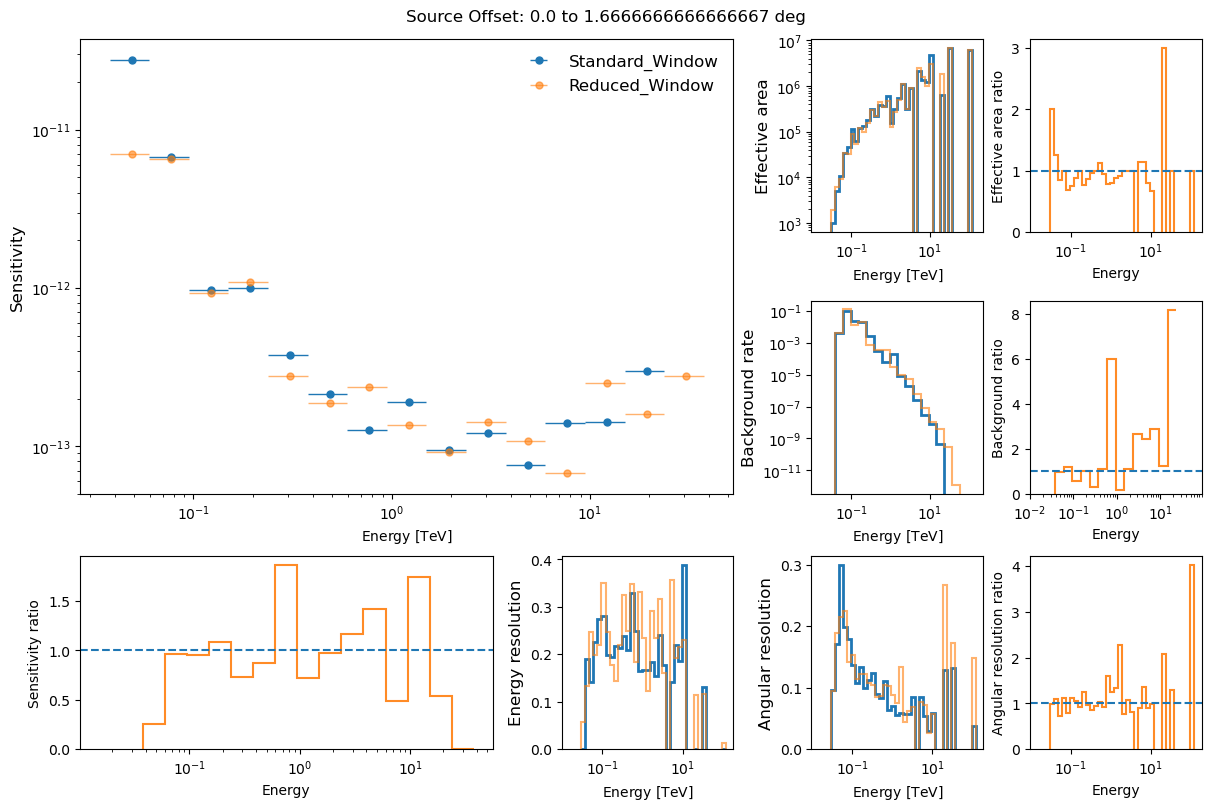

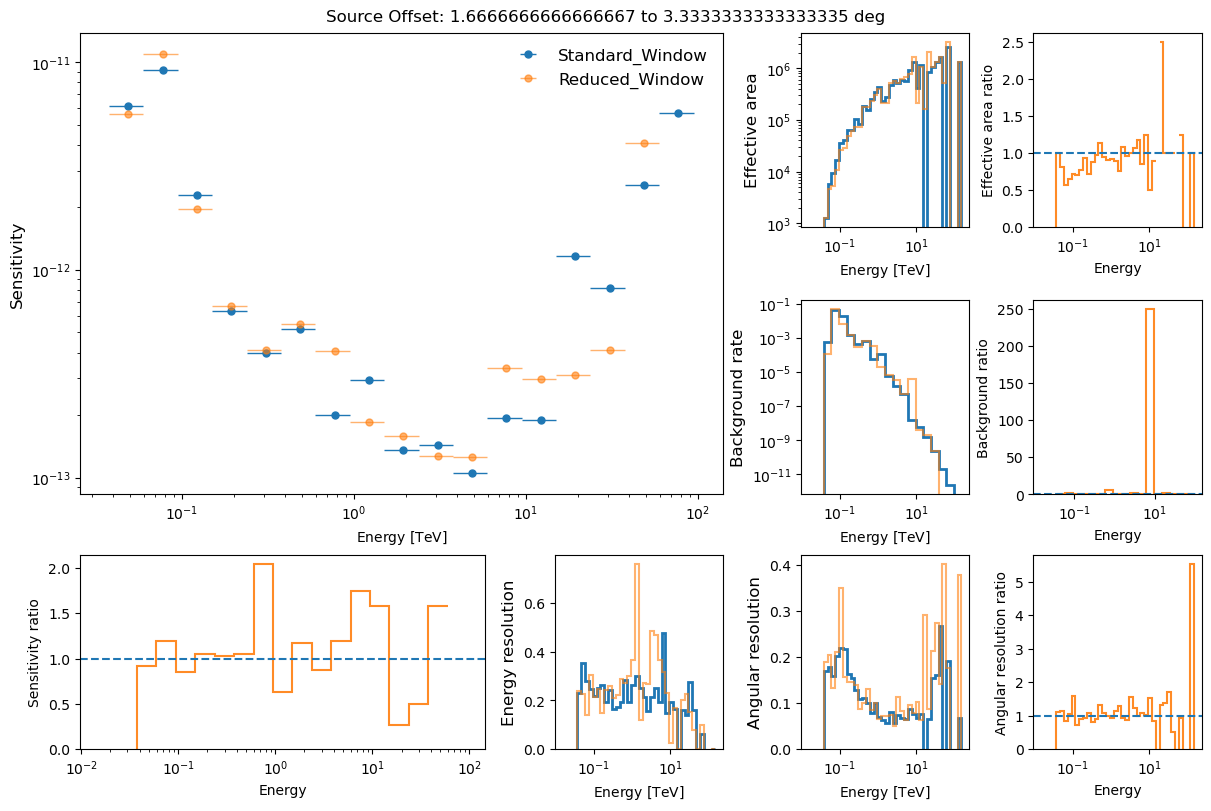

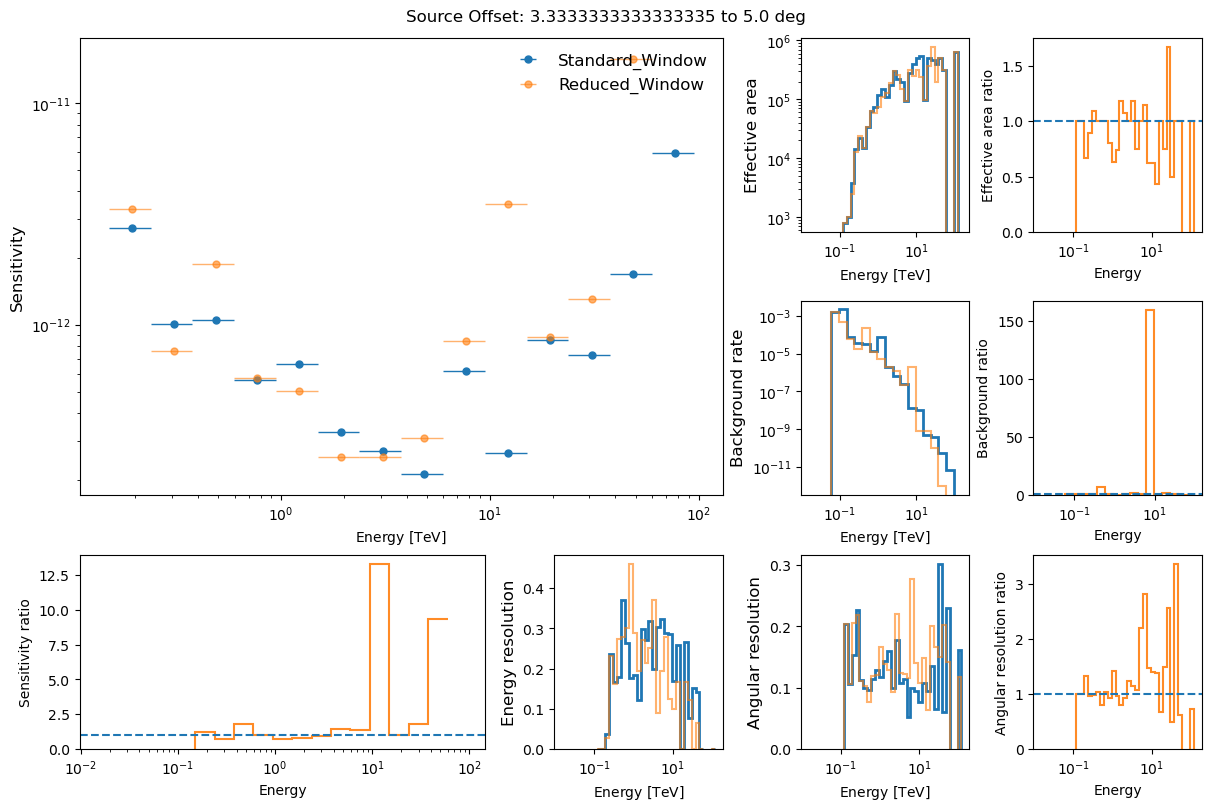

In [33]:

new_results = ResultStore(results_path / "study2")
for benchmark in benchmark_list:
    benchmark.compare_to_reference(loaded_metric_list, new_results)

## Accessing individual plots from the intermediate experiment data

In the directory created by the `ResultsStore` for our study above, all the PDF plots will be in subdirectories. 

In [15]:
! tree $results_path

/tmp/Studies
└── study2
    ├── dl3
    │   └── instrument_response_functions
    │       ├── Performance_comparison_results.json
    │       ├── PerformancePlot_Offset_0.0 to 1.pdf
    │       ├── PerformancePlot_Offset_1.6666666666666667 to 3.pdf
    │       └── PerformancePlot_Offset_3.3333333333333335 to 5.pdf
    └── metadata.json

4 directories, 5 files


 But can can also look at the raw data from any of the experiments as well: 

In [16]:
metric_store_list[1].contents()

['dl3/instrument_response_functions/AngularResolution.asdf',
 'dl3/instrument_response_functions/Background.asdf',
 'dl3/instrument_response_functions/EffectiveArea.asdf',
 'dl3/instrument_response_functions/EnergyBiasResolution.asdf',
 'dl3/instrument_response_functions/EnergyMigration.asdf',
 'dl3/instrument_response_functions/RadMax.asdf',
 'dl3/instrument_response_functions/Sensitivity.asdf']

In [17]:
bgmetric = metric_store_list[1].retrieve_data(
    "dl3/instrument_response_functions/Background.asdf"
)

[]

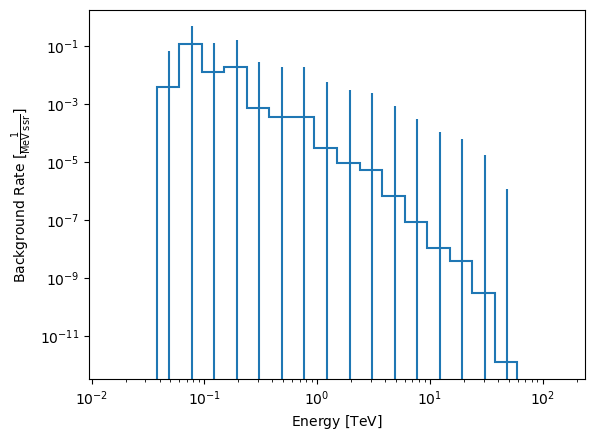

In [18]:
bgmetric[0, :].plot()
plt.loglog()